# Routing Challenge

## Import libs and download dataset

In [9]:
import json
import random
import collections
import enum
import typing
import datetime
import os
import sys

from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import spatial
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl

import argparse
import logging
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import utils
import score
import model.net as net
import model.dataset as dataset
import model.loss as loss
from beam_search import *
from score import *

mpl.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [10]:
sys.argv = ['']
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(" ")))

parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default=os.path.join(BASE_DIR, 'data'),
                    help="Directory containing the dataset")
parser.add_argument('--model_dir', default=os.path.join(BASE_DIR, 'experiments/base_model'),
                    help="Directory containing params.json")
parser.add_argument('--restore_file', default=None,
                    help="Optional, name of the file in --model_dir containing weights to reload before \
                    training")  # 'best' or 'train'
args = parser.parse_args()
json_path = os.path.join(args.model_dir, 'params.json')
# assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

torch.manual_seed(230)

In [3]:
datasets = dataset.get_dataset(["build"], args.data_dir)
build_dataset = datasets["build"]

In [11]:
model = net.RouteNetV3(router_embbed_dim=params.router_embbed_dim, num_routers=params.num_routers, dropout=params.dropout_rate)
checkpoint = torch.load("/home/jigao95/routing/experiments/base_model/best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.eval()

RouteNetV3(
  (inp_layer): InputFusion(
    (input): Conv2d(42, 54, kernel_size=(1, 1), stride=(1, 1))
    (input_0): Sequential(
      (0): Linear(in_features=9, out_features=210, bias=False)
      (1): ReLU()
      (2): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=210, out_features=420, bias=True)
    )
  )
  (out_layer): SelfAttention(
    (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (queries): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (keys): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (values): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (pool): AdaptiveAvgPool2d(output_size=(None, 1))
  )
  (routers): ModuleList(
    (0): Router(
      (attention): SelfAttention(
        (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (queries): Conv2d(64, 8, kernel

In [22]:
train_set, val_set, others = torch.utils.data.random_split(build_dataset, [params.train, params.val, len(build_dataset)-params.train-params.val])
train_sampler = dataset.BucketSampler([route.num_stops for route in train_set], batch_size=1, shuffle=True, drop_last=True)
val_sampler = dataset.BucketSampler([route.num_stops for route in val_set], batch_size=1, shuffle=True)
collate_fn = dataset.get_collate_fn(stage="build", params=params)

train_loader = dataset.DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate_fn)
val_loader = dataset.DataLoader(val_set, batch_sampler=val_sampler, collate_fn=collate_fn)

In [23]:
# Train for one epoch
batch = 0
batch = next(iter(val_loader))

inputs = batch['inputs'] # (n, max_num_stops, max_num_stops, num_1d_features + num_2d_features)
input_0ds = batch['input_0ds'] # (n, num_0d_features)
targets = batch['targets'] # (n, max_num_stops)
masks = batch['masks'] # (n, max_num_stops, max_num_stops)
sequence_maps = batch["sequence_maps"]
route_ids = batch["route_ids"]

print(route_ids)
# print(sequence_maps)

outputs = model(inputs, input_0ds, masks)
output = outputs.squeeze().detach().numpy()
print (output.shape)
print (output)

('RouteID_2438aa1b-bbc0-490e-8ecf-ae4fcf444217',)
(193, 193)
[[ -2.1218696 -15.042757   -4.58121   ...  -6.925046  -14.279367
  -14.753979 ]
 [-14.540163   -2.612857  -14.648666  ... -15.472983   -7.267806
  -11.134783 ]
 [ -4.323742  -15.019986   -2.2654028 ...  -6.181747  -17.326248
  -12.043043 ]
 ...
 [ -8.025152  -18.462536   -7.180418  ...  -2.4870028 -11.716682
  -13.901861 ]
 [-15.668032   -8.021462  -18.321959  ... -11.661256   -2.4977055
  -12.113539 ]
 [-16.849045   -9.913466  -13.110659  ... -13.414214  -10.8204775
   -2.4633331]]


In [24]:
# Get dist matrix
dist_matrix =  build_dataset.travel_times_dict[route_ids[0]]

# Compute output sequence
starting_node = list(list(batch['sequences'])[0].keys()).index(0)
rank = beam_search(start_node=starting_node, weight_matrix=np.exp(output)*50, num_beam=int(0.8*output.shape[0])).tolist()
rank.append(rank[0])
# print (rank)

a = list(list(batch["sequence_maps"])[0].keys())
rank0 = [0]*len(rank)
for i in range(len(rank)):
    rank0[i] = a[rank[i]]

# Compute target sequence
target_list = list(list(batch['sequences'])[0].keys())
actual = [0]*len(target_list)
for i in range (len(target_list)):
    actual[target_list[i]] = i
actual.append(actual[0])

actual0 = [0]*len(rank)
for i in range(len(rank)):
    actual0[i] = a[actual[i]]

print (rank0)
print (actual0) 
print ("seq_dev",seq_dev(actual0, rank0))
print ("score",score(actual0,rank0,dist_matrix))

max cumulative probability:  2.0863895715736577e+87
['JC', 'YM', 'OY', 'OR', 'HO', 'CT', 'GQ', 'RW', 'YJ', 'ZH', 'YA', 'YD', 'IX', 'TJ', 'WM', 'JP', 'ZA', 'GV', 'XG', 'VZ', 'FH', 'ZF', 'YV', 'EP', 'UE', 'LL', 'AB', 'OT', 'TM', 'XO', 'CV', 'EJ', 'QY', 'KC', 'UX', 'WS', 'YT', 'RJ', 'YE', 'NQ', 'BD', 'TT', 'NP', 'WJ', 'QE', 'DU', 'RQ', 'BA', 'JZ', 'JT', 'QM', 'LU', 'WU', 'NR', 'KL', 'PO', 'KD', 'UD', 'JL', 'NB', 'ON', 'CU', 'HQ', 'XX', 'KR', 'UU', 'SG', 'IG', 'EX', 'WO', 'DJ', 'JS', 'PF', 'OP', 'AE', 'JI', 'GZ', 'FW', 'YS', 'IL', 'YG', 'TE', 'DZ', 'XI', 'AL', 'MQ', 'AW', 'MD', 'EV', 'SZ', 'IJ', 'MY', 'FR', 'NL', 'YH', 'TX', 'US', 'MZ', 'XL', 'UG', 'KG', 'BW', 'RP', 'UC', 'WI', 'VF', 'CN', 'OV', 'OX', 'SW', 'BC', 'OZ', 'DA', 'RC', 'IE', 'ZV', 'MI', 'KF', 'DK', 'JU', 'VI', 'EU', 'FI', 'QR', 'GN', 'BN', 'DT', 'GL', 'XN', 'RO', 'UQ', 'LR', 'XW', 'FF', 'KY', 'DS', 'QH', 'HJ', 'AD', 'BO', 'KU', 'SA', 'OS', 'JN', 'BU', 'UM', 'QI', 'HR', 'FJ', 'CS', 'YB', 'DC', 'BM', 'QV', 'MV', 'VC', 'SH', 'SJ',

In [25]:
len(val_loader)

200

In [29]:
seq_dev_list = []
score_list = []

for _ in range(50):
    batch = next(iter(val_loader))

    inputs = batch['inputs'] # (n, max_num_stops, max_num_stops, num_1d_features + num_2d_features)
    input_0ds = batch['input_0ds'] # (n, num_0d_features)
    targets = batch['targets'] # (n, max_num_stops)
    masks = batch['masks'] # (n, max_num_stops, max_num_stops)
    sequence_maps = batch["sequence_maps"]
    route_ids = batch["route_ids"]

    outputs = model(inputs, input_0ds, masks)
    output = outputs.squeeze().detach().numpy()

    # Get dist matrix
    dist_matrix =  build_dataset.travel_times_dict[route_ids[0]]

    # Compute output sequence
    starting_node = list(list(batch['sequences'])[0].keys()).index(0)
    rank = beam_search(start_node=starting_node, weight_matrix=np.exp(output)*100, num_beam=int(0.8*output.shape[0])).tolist()
    rank.append(rank[0])
    # print (rank)

    a = list(list(batch["sequence_maps"])[0].keys())
    rank0 = [0]*len(rank)
    for i in range(len(rank)):
        rank0[i] = a[rank[i]]

    # Compute target sequence
    target_list = list(list(batch['sequences'])[0].keys())
    actual = [0]*len(target_list)
    for i in range (len(target_list)):
        actual[target_list[i]] = i
    actual.append(actual[0])

    actual0 = [0]*len(rank)
    for i in range(len(rank)):
        actual0[i] = a[actual[i]]
    
    
    seq_dev_val = seq_dev(actual0, rank0)
    score_val = score(actual0,rank0,dist_matrix)
    score_list.append(score_val)
    seq_dev_list.append(seq_dev_val)
    print ("seq_dev",seq_dev_val, "score",score_val)

print (np.mean(seq_dev_list))
print (np.mean(score_list))

max cumulative probability:  0.0
seq_dev -0.0021786492374727667 score -0.0019913740219829968
max cumulative probability:  91452235.21183605
seq_dev 0.612994350282486 score 0.36277223086609406
max cumulative probability:  4.6955307638887385e-26
seq_dev 0.5237487231869254 score 0.6100749226709469
max cumulative probability:  9.243483339341828e+126
seq_dev 0.058961038961038964 score 0.07281144262908178
max cumulative probability:  4.0691054998162676e-07
seq_dev 0.5236694677871148 score 0.7733868306704502
max cumulative probability:  0.008936970263867094
seq_dev 0.5138820839457782 score 0.8011768682669634
max cumulative probability:  0.0
seq_dev 0.006138735420503376 score 0.007826797494138808
max cumulative probability:  1.1919870293635955e-65
seq_dev 0.5450479930191973 score 1.0384519979555271
max cumulative probability:  6.9591158229496245e-65
seq_dev 0.5133946421431428 score 0.6417449992275901
max cumulative probability:  2457216987.8279057
seq_dev 0.531353963969619 score 0.882930301812

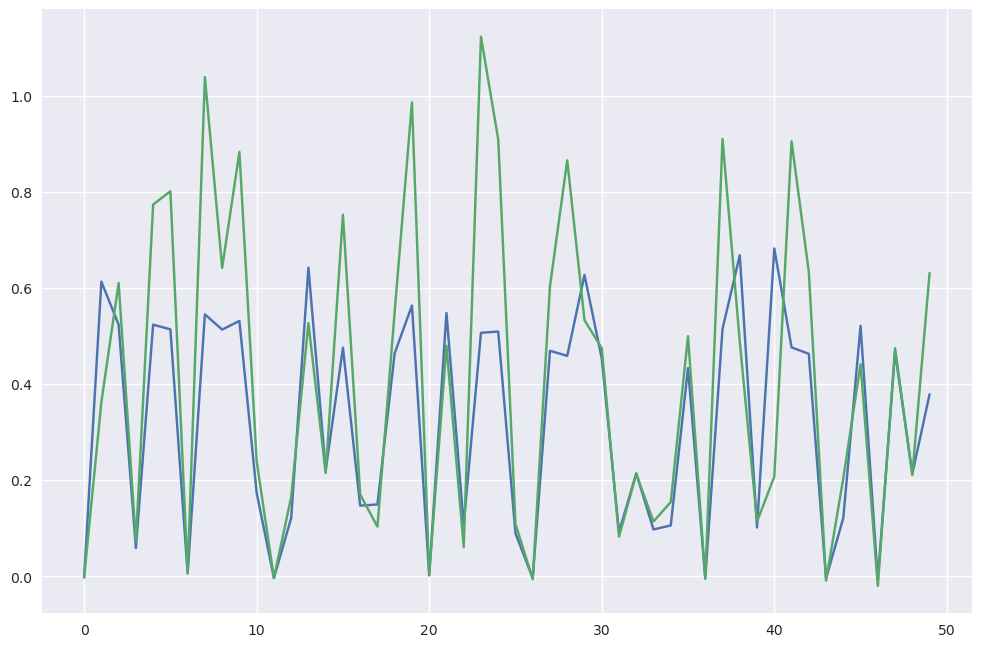

In [30]:
plt.plot (seq_dev_list)
plt.plot (score_list)

In [33]:
# scoring 
def score(actual,sub,cost_mat,g=1000):
    '''
    Scores individual routes.
    Parameters
    ----------
    actual : list
        Actual route.
    sub : list
        Submitted route.
    cost_mat : dict
        Cost matrix.
    g : int/float, optional
        ERP gap penalty. Irrelevant if large and len(actual)==len(sub). The
        default is 1000.
    Returns
    -------
    float
        Accuracy score from comparing sub to actual.
    '''
    norm_mat=normalize_matrix(cost_mat)
    return seq_dev(actual,sub)*erp_per_edit(actual,sub,norm_mat,g)

def erp_per_edit(actual,sub,matrix,g=1000):
    '''
    Outputs ERP of comparing sub to actual divided by the number of edits involved
    in the ERP. If there are 0 edits, returns 0 instead.
    Parameters
    ----------
    actual : list
        Actual route.
    sub : list
        Submitted route.
    matrix : dict
        Normalized cost matrix.
    g : int/float, optional
        ERP gap penalty. The default is 1000.
    Returns
    -------
    int/float
        ERP divided by number of ERP edits or 0 if there are 0 edits.
    '''
    total,count=erp_per_edit_helper(actual,sub,matrix,g)
    if count==0:
        return 0
    else:
        return total/count

def erp_per_edit_helper(actual,sub,matrix,g=1000,memo=None):
    '''
    Calculates ERP and counts number of edits in the process.
    Parameters
    ----------
    actual : list
        Actual route.
    sub : list
        Submitted route.
    matrix : dict
        Normalized cost matrix.
    g : int/float, optional
        Gap penalty. The default is 1000.
    memo : dict, optional
        For memoization. The default is None.
    Returns
    -------
    d : float
        ERP from comparing sub to actual.
    count : int
        Number of edits in ERP.
    '''
    if memo==None:
        memo={}
    actual_tuple=tuple(actual)
    sub_tuple=tuple(sub)
    if (actual_tuple,sub_tuple) in memo:
        d,count=memo[(actual_tuple,sub_tuple)]
        return d,count
    if len(sub)==0:
        d=gap_sum(actual,g)
        count=len(actual)
    elif len(actual)==0:
        d=gap_sum(sub,g)
        count=len(sub)
    else:
        head_actual=actual[0]
        head_sub=sub[0]
        rest_actual=actual[1:]
        rest_sub=sub[1:]
        score1,count1=erp_per_edit_helper(rest_actual,rest_sub,matrix,g,memo)
        score2,count2=erp_per_edit_helper(rest_actual,sub,matrix,g,memo)
        score3,count3=erp_per_edit_helper(actual,rest_sub,matrix,g,memo)
        option_1=score1+dist_erp(head_actual,head_sub,matrix,g)
        option_2=score2+dist_erp(head_actual,'gap',matrix,g)
        option_3=score3+dist_erp(head_sub,'gap',matrix,g)
        d=min(option_1,option_2,option_3)
        if d==option_1:
            if head_actual==head_sub:
                count=count1
            else:
                count=count1+1
        elif d==option_2:
            count=count2+1
        else:
            count=count3+1
    memo[(actual_tuple,sub_tuple)]=(d,count)
    return d,count

def normalize_matrix(mat):
    '''
    Normalizes cost matrix.
    Parameters
    ----------
    mat : dict
        Cost matrix.
    Returns
    -------
    new_mat : dict
        Normalized cost matrix.
    '''
    new_mat=mat.copy()
    time_list=[]
    for origin in mat:
        for destination in mat[origin]:
            time_list.append(mat[origin][destination])
    avg_time=np.mean(time_list)
    std_time=np.std(time_list)
    min_new_time=np.inf
    for origin in mat:
        for destination in mat[origin]:
            old_time=mat[origin][destination]
            new_time=(old_time-avg_time)/std_time
            if new_time<min_new_time:
                min_new_time=new_time
            new_mat[origin][destination]=new_time
    for origin in new_mat:
        for destination in new_mat[origin]:
            new_time=new_mat[origin][destination]
            shifted_time=new_time-min_new_time
            new_mat[origin][destination]=shifted_time
    return new_mat

def gap_sum(path,g):
    '''
    Calculates ERP between two sequences when at least one is empty.
    Parameters
    ----------
    path : list
        Sequence that is being compared to an empty sequence.
    g : int/float
        Gap penalty.
    Returns
    -------
    res : int/float
        ERP between path and an empty sequence.
    '''
    res=0
    for p in path:
        res+=g
    return res

def dist_erp(p_1,p_2,mat,g=1000):
    '''
    Finds cost between two points. Outputs g if either point is a gap.
    Parameters
    ----------
    p_1 : str
        ID of point.
    p_2 : str
        ID of other point.
    mat : dict
        Normalized cost matrix.
    g : int/float, optional
        Gap penalty. The default is 1000.
    Returns
    -------
    dist : int/float
        Cost of substituting one point for the other.
    '''
    if p_1=='gap' or p_2=='gap':
        dist=g
    else:
        dist=mat[p_1][p_2]
    return dist

def seq_dev(actual,sub):
    actual=actual[1:-1]
    sub=sub[1:-1]
    comp_list=[]
    for i in sub:
        comp_list.append(actual.index(i))
        comp_sum=0
    for ind in range(1,len(comp_list)):
        comp_sum+=abs(comp_list[ind]-comp_list[ind-1])-1
    n=len(actual)
    return (2/(n*(n-1)))*comp_sum